In [ ]:
num_weeks = 12

## VENTAS

In [39]:
import xmlrpc.client
from datetime import date, timedelta, datetime
import pandas as pd

# Conexión con Odoo (manteniendo tus credenciales)
username = "juan.cano@donsson.com"  # tu usuario
password = "1000285668"         # tu contraseña
url = "https://donsson.com"     # URL del servidor
db = "Donsson_produccion" # nombre de la base de datos


# --- Autenticación ---
common = xmlrpc.client.ServerProxy(f"{url}/xmlrpc/2/common")
uid = common.authenticate(db, username, password, {})
models = xmlrpc.client.ServerProxy(f"{url}/xmlrpc/2/object")

# --- Fechas ---
weeks = num_weeks

# --- Fechas automáticas ---
hoy = date.today()
fecha_fin = hoy.strftime("%Y-%m-%d")
fecha_inicio = (hoy - timedelta(weeks=weeks)).strftime("%Y-%m-%d")

# --- 1) Buscar facturas válidas (account.invoice) ---

invoice_domain = [
    ("date_invoice", ">=", fecha_inicio),
    ("date_invoice", "<=", fecha_fin),
    ("type", "=", "out_invoice"),    # solo ventas
    ("state", "in", ["open", "paid"])
]

invoice_ids = models.execute_kw(
    db, uid, password,
    "account.invoice", "search",
    [invoice_domain]
)
print(f"Facturas encontradas: {len(invoice_ids)}")

# --- 2) Descargar las líneas de esas facturas (account.invoice.line) ---

# Campos de la LÍNEA de factura. Eliminamos 'number', 'user_id', 'section_id', 'partner_id' porque irán en la factura.
line_fields = ["product_id", "quantity", "price_subtotal", "invoice_id","create_date","origin"] 

records = []
limit = 20000
offset = 0

while True:
    result = models.execute_kw(
        db, uid, password,
        "account.invoice.line", "search_read",
        [[("invoice_id", "in", invoice_ids)]],
        {"fields": line_fields, "limit": limit, "offset": offset}
    )
    if not result:
        break
    records.extend(result)
    offset += limit
    print(f"Descargados {len(records)} registros de líneas...")

# --- 3) Pasar a DataFrame de líneas ---
line_df = pd.DataFrame(records).fillna(0)


# Separar product_id
line_df["product_id_num"] = line_df["product_id"].apply(
    lambda x: x[0] if isinstance(x, (list, tuple)) else None
)
line_df["product_name"] = line_df["product_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else str(x)
)

# Separar invoice_id
line_df["invoice_id_num"] = line_df["invoice_id"].apply(
    lambda x: x[0] if isinstance(x, (list, tuple)) else None
)
line_df["invoice_name"] = line_df["invoice_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else str(x)
)

# Convertir fecha a datetime
line_df["date_invoice"] = pd.to_datetime(line_df["create_date"], errors="coerce")

# Eliminar las columnas originales problemáticas
line_df = line_df.drop(columns=["product_id", "invoice_id","create_date"])

print(f"Total de líneas descargadas: {len(line_df)}")

# ----------------------------------------------------
# --- 4) Descargar los campos adicionales de Factura (account.invoice) ---
# ----------------------------------------------------
# Añadimos los campos que quieres: number, user_id, section_id, y también partner_id y store_id
invoice_fields = ["id", "store_id", "number", "user_id", "section_id", "partner_id"]
invoices = models.execute_kw(
    db, uid, password,
    "account.invoice", "read",
    [invoice_ids], # Solo las facturas que encontramos
    {"fields": invoice_fields}
)
invoice_df = pd.DataFrame(invoices)

# --- 5) Procesar campos de la factura ---

# Separar store_id
invoice_df["store_name"] = invoice_df["store_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else str(x)
)

# Separar user_id (Vendedor)
invoice_df["salesperson_name"] = invoice_df["user_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else None
)

# Separar section_id (Equipo de Ventas)
invoice_df["sales_team_name"] = invoice_df["section_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else None
)

# Separar partner_id (Cliente/Partner)
invoice_df["partner_id_num"] = invoice_df["partner_id"].apply(
    lambda x: x[0] if isinstance(x, (list, tuple)) else None
)
# El nombre del partner es el segundo elemento de la tupla (si existe)
invoice_df["client_name_inv"] = invoice_df["partner_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else None
)


# Eliminar columnas originales no deseadas o ya procesadas
invoice_df = invoice_df.drop(columns=["store_id", "user_id", "section_id", "partner_id"])


# ----------------------------------------------------
# --- 6) Fusionar DataFrames ---
# ----------------------------------------------------

# Fusionamos las líneas de factura (line_df) con los datos de las facturas (invoice_df)
df = line_df.merge(
    invoice_df, 
    left_on="invoice_id_num", 
    right_on="id", 
    how="left"
)

# Limpieza final de columnas de IDs de factura
df = df.drop(columns=["invoice_id_num", "product_id_num"])


df['origin'] = df['origin'].astype('string')

# 2 minutos 15 semanas

Facturas encontradas: 24820
Descargados 20000 registros de líneas...
Descargados 40000 registros de líneas...
Descargados 60000 registros de líneas...
Descargados 80000 registros de líneas...
Descargados 96229 registros de líneas...
Total de líneas descargadas: 96229


In [40]:
df.head()

,origin,price_subtotal,id_x,quantity,product_name,invoice_name,date_invoice,number,id_y,store_name,salesperson_name,sales_team_name,partner_id_num,client_name_inv
0,False,288000.0,1629871,6.0,[DAB09218025] DA9218 FILTRO AIRE SEGURIDAD - S...,PV2E43959 Mostrador Calle 6 T4/14063,2025-10-07 16:53:51,PV2E43959,441876,SUCURSAL CALLE 6,AURELYSMAR REA SILVA,SUCURSALES / Ventas Mostrador Cll6,36868,[CO9017040358] COLFILTROS INGENIERIA S.A.S.
1,False,562800.0,1629870,6.0,[DAB08218025] DA8218 FILTRO AIRE - SEM - SDLG ...,PV2E43959 Mostrador Calle 6 T4/14063,2025-10-07 16:53:51,PV2E43959,441876,SUCURSAL CALLE 6,AURELYSMAR REA SILVA,SUCURSALES / Ventas Mostrador Cll6,36868,[CO9017040358] COLFILTROS INGENIERIA S.A.S.
2,False,31500.0,1629873,1.0,[DAB02570025] DA2570 FILTRO AIRE DONSSON - PER...,PV2E43959 Mostrador Calle 6 T4/14063,2025-10-07 16:53:51,PV2E43959,441876,SUCURSAL CALLE 6,AURELYSMAR REA SILVA,SUCURSALES / Ventas Mostrador Cll6,36868,[CO9017040358] COLFILTROS INGENIERIA S.A.S.
3,False,25500.0,1629872,1.0,[DAB14570025] DA4570A FILTRO AIRE 2_ DONSSON -...,PV2E43959 Mostrador Calle 6 T4/14063,2025-10-07 16:53:51,PV2E43959,441876,SUCURSAL CALLE 6,AURELYSMAR REA SILVA,SUCURSALES / Ventas Mostrador Cll6,36868,[CO9017040358] COLFILTROS INGENIERIA S.A.S.
4,False,6800.0,1629869,1.0,[DCE00165145] G165 FILTRO COMBUSTIBLE MAGNETIC...,PV3E20114 Mostrador Valladolid T2/15419,2025-10-07 16:53:23,PV3E20114,441875,SUCURSAL VALLADOLID,SEBAS RODRIGUEZ,SUCURSALES / Ventas Mostrador Valladolid,7777,[CC79647425] NELSON ORLANDO ROJAS


## VENTAS PERDIDAS

In [41]:
import xmlrpc.client
from datetime import date, timedelta
import pandas as pd

# ===============================
# 1. Conexión con Odoo
# ===============================

ODOO_URL = "https://donsson.com"
ODOO_DB = "Donsson_produccion"
ODOO_USERNAME = "juan.cano@donsson.com"
ODOO_PASSWORD = "1000285668"

# Autenticación
common = xmlrpc.client.ServerProxy(f"{ODOO_URL}/xmlrpc/2/common")
uid = common.authenticate(ODOO_DB, ODOO_USERNAME, ODOO_PASSWORD, {})
if not uid:
    print("Error de autenticación. Verifica tus credenciales.")
    exit()
models = xmlrpc.client.ServerProxy(f"{ODOO_URL}/xmlrpc/2/object")

# ===============================
# 2. Definir rango de semanas
# ===============================

# Número de semanas que quieres descargar (puedes cambiarlo)
NUM_SEMANAS = num_weeks

# Fecha de hoy
hoy = date.today()
# Fecha de inicio según número de semanas atrás
fecha_inicio = hoy - timedelta(weeks=NUM_SEMANAS)

FECHA_INICIO = fecha_inicio.strftime("%Y-%m-%d")
FECHA_FIN = hoy.strftime("%Y-%m-%d")

print(f"📅 Descargando registros desde {FECHA_INICIO} hasta {FECHA_FIN}")

# ===============================
# 3. Leer ventas perdidas
# ===============================

lost_sales_ids = models.execute_kw(
    ODOO_DB, uid, ODOO_PASSWORD,
    "ventas.perdidas", "search",
    [[["fecha", ">=", FECHA_INICIO], ["fecha", "<=", FECHA_FIN], ["almacenamiento_tipo", "=", "agotado"]]]
)

lost_sales_data = models.execute_kw(
    ODOO_DB, uid, ODOO_PASSWORD,
    "ventas.perdidas", "read",
    [lost_sales_ids],
    {"fields": ["origen", "store_id", "cliente_id", "fecha", "product_ref",
                "cantidad", "cantidad_existencia", "cantidad_reservada",
                "almacenamiento_tipo"]}
)

df_vp = pd.DataFrame(lost_sales_data)

# ===============================
# 4. Normalizar columnas
# ===============================

for col in ["store_id", "cliente_id"]:
    df_vp[col.replace('_id', '_name')] = df_vp[col].apply(
        lambda x: x[1] if isinstance(x, (list, tuple)) and len(x) > 1 else str(x) if x else None
    )
    df_vp[col + "_num"] = df_vp[col].apply(
        lambda x: x[0] if isinstance(x, (list, tuple)) and len(x) > 0 else None
    )

# Eliminar columnas originales
df_vp = df_vp.drop(columns=["id", "store_id", "cliente_id"], errors='ignore')

# ===============================
# 4.1. Forzar tipos de columnas antes de exportar
# ===============================
for col in df_vp.columns:
    if col.endswith("_num"):
        df_vp[col] = pd.to_numeric(df_vp[col], errors="coerce").astype("Int64")
    else:
        df_vp[col] = df_vp[col].astype("string")

df_vp = df_vp.copy()


📅 Descargando registros desde 2025-04-22 hasta 2025-10-07


In [42]:
import pandas as pd
import numpy as np

# ===============================
# Filtrar almacenamiento agotado
# ===============================
df_vp = df_vp[df_vp["almacenamiento_tipo"].str.lower() == "agotado"]

# ===============================
# Asegurar tipos correctos
# ===============================
df_vp = df_vp.copy()
df_vp["fecha"] = pd.to_datetime(df_vp["fecha"], errors="coerce")

# Numéricos
for col in ["cantidad", "cantidad_existencia", "cantidad_reservada"]:
    df_vp[col] = pd.to_numeric(df_vp[col], errors="coerce").fillna(0).clip(lower=0)

# ===============================
# Reglas Odoo vectorizadas
# ===============================
is_cot = df_vp["origen"].fillna("").str.lower() == "cotizacion"
ignore_mask = df_vp["cantidad"] >= 100

ajuste = np.where(
    is_cot,
    df_vp["cantidad"] - df_vp["cantidad_existencia"] - df_vp["cantidad_reservada"],
    df_vp["cantidad"] - df_vp["cantidad_reservada"]
)

# Aplicar reglas de descarte y piso en cero
ajuste = np.where(ignore_mask, 0, ajuste)
ajuste = np.where(ajuste > 0, ajuste, 0)

df_vp["ventas_perdidas"] = ajuste.astype(float)

# ===============================
# Columnas temporales
# ===============================
df_vp["Semana"] = df_vp["fecha"].dt.to_period("W").dt.start_time
df_vp["ano"]   = df_vp["Semana"].dt.year
df_vp["mes"]   = df_vp["Semana"].dt.month
df_vp["dia"]   = df_vp["Semana"].dt.day

# ===============================
# Filtro adicional: excluir SERV y CARCASA
# ===============================
mask_excluir = ~df_vp["product_ref"].str.contains("SERV|CARCASA", case=False, na=False)
df_vp = df_vp[mask_excluir]

# ===============================
# Agrupación por tienda + producto + semana
# ===============================
lost_by_week = (
    df_vp.groupby(["store_name", "product_ref", "Semana", "ano", "mes", "dia"])
    .agg(
        lost_sales=("ventas_perdidas", "sum"),   # suma total de ventas perdidas
        veces_vp=("ventas_perdidas", "count")    # número de veces que hubo pérdida
    )
    .reset_index()
)

# Mostrar resultado agrupado
vp_week = lost_by_week

In [43]:
vp_week.head()

,store_name,product_ref,Semana,ano,mes,dia,lost_sales,veces_vp
0,PRINCIPAL COTA,AC10388020,2025-09-22,2025,9,22,36.0,4
1,PRINCIPAL COTA,AGB0GRAS030,2025-07-28,2025,7,28,1.0,1
2,PRINCIPAL COTA,AHB80W90030,2025-07-07,2025,7,7,1.0,1
3,PRINCIPAL COTA,AHB80W90050,2025-08-11,2025,8,11,1.0,1
4,PRINCIPAL COTA,AHBNTO68030,2025-04-28,2025,4,28,4.0,1


## COSTOS

In [44]:
import xmlrpc.client
import pandas as pd


# ===============================
# Conexión con Odoo
# ===============================
username = "juan.cano@donsson.com"   # tu usuario
password = "1000285668"              # tu contraseña
url = "https://donsson.com"          # URL del servidor
db = "Donsson_produccion"            # nombre de la base de datos

common = xmlrpc.client.ServerProxy(f"{url}/xmlrpc/2/common")
uid = common.authenticate(db, username, password, {})
models = xmlrpc.client.ServerProxy(f"{url}/xmlrpc/2/object")


#df_campos.info()


productos_costo = models.execute_kw(
    db , uid , password,
    "cs.analisis.costo","search_read",
    [[]],
    {"fields":["producto_costo_unitario","producto_id"]}


)

# Convertir en df
df_p = pd.DataFrame(productos_costo)


# Separar lista anidada
df_p[["product_id_num","product_name"]] = (df_p["producto_id"].apply(pd.Series))

#Agregar columna estandarizada
df_p["product_name"] = df_p["product_name"].str.strip()

#DF normalizado
df_p = df_p[["product_name","producto_costo_unitario"]]

In [45]:
df.head()

,origin,price_subtotal,id_x,quantity,product_name,invoice_name,date_invoice,number,id_y,store_name,salesperson_name,sales_team_name,partner_id_num,client_name_inv
0,False,288000.0,1629871,6.0,[DAB09218025] DA9218 FILTRO AIRE SEGURIDAD - S...,PV2E43959 Mostrador Calle 6 T4/14063,2025-10-07 16:53:51,PV2E43959,441876,SUCURSAL CALLE 6,AURELYSMAR REA SILVA,SUCURSALES / Ventas Mostrador Cll6,36868,[CO9017040358] COLFILTROS INGENIERIA S.A.S.
1,False,562800.0,1629870,6.0,[DAB08218025] DA8218 FILTRO AIRE - SEM - SDLG ...,PV2E43959 Mostrador Calle 6 T4/14063,2025-10-07 16:53:51,PV2E43959,441876,SUCURSAL CALLE 6,AURELYSMAR REA SILVA,SUCURSALES / Ventas Mostrador Cll6,36868,[CO9017040358] COLFILTROS INGENIERIA S.A.S.
2,False,31500.0,1629873,1.0,[DAB02570025] DA2570 FILTRO AIRE DONSSON - PER...,PV2E43959 Mostrador Calle 6 T4/14063,2025-10-07 16:53:51,PV2E43959,441876,SUCURSAL CALLE 6,AURELYSMAR REA SILVA,SUCURSALES / Ventas Mostrador Cll6,36868,[CO9017040358] COLFILTROS INGENIERIA S.A.S.
3,False,25500.0,1629872,1.0,[DAB14570025] DA4570A FILTRO AIRE 2_ DONSSON -...,PV2E43959 Mostrador Calle 6 T4/14063,2025-10-07 16:53:51,PV2E43959,441876,SUCURSAL CALLE 6,AURELYSMAR REA SILVA,SUCURSALES / Ventas Mostrador Cll6,36868,[CO9017040358] COLFILTROS INGENIERIA S.A.S.
4,False,6800.0,1629869,1.0,[DCE00165145] G165 FILTRO COMBUSTIBLE MAGNETIC...,PV3E20114 Mostrador Valladolid T2/15419,2025-10-07 16:53:23,PV3E20114,441875,SUCURSAL VALLADOLID,SEBAS RODRIGUEZ,SUCURSALES / Ventas Mostrador Valladolid,7777,[CC79647425] NELSON ORLANDO ROJAS


# EDA

## Facturas

In [46]:
import re
import unicodedata



mapa_sucursales = {
    'BD1': 'PRINCIPAL COTA',
    'BD2': 'SUCURSAL CALLE 6',
    'BD3': 'SUCURSAL VALLADOLID',
    'BD4': 'SUCURSAL NORTE',
    'BD5': 'SUCURSAL MEDELLIN',
    'BD6': 'SUCURSAL BARRANQUILLA',
    'BD7':' SUCURSAL BUCARAGAMNGA ',
    'BD8':'MOSTRADOR COTA',
    'BD9':'SUCURSAL CALI',
    'BD11': 'CUMMINS DE LOS ANDES',
    'BD12': 'CUMMINS DE LOS ANDES MEDELLIN',
    'BD13': 'CSS CONSTRUCTORES',
    'BD14': 'ANTIOQUEÑA DE LUBRICANTES SGP SAS',
    'BD15': 'ASEO CAPITAL',
    'BD16': 'COVIANDES',
    'BD18': 'CEMEX BOSA',
    'BD19': 'Cemex ibague (eliminar)',
    'BD21': 'CEMEX CENTENARIO',
    'BD22': 'PENDIENTE POR FACTURAR CIERRE CONT.',
    'BD24': 'FILTRO EN REPROCESO',
    'BD26': 'PRESTAMOS INTERNOS',
    'BD31': 'EXP.CTP',
    'BD32': 'EXP. ECUADOR',
    'BD34':'EXP.DONSSON.USA',
    'BD40': 'DESCUADRE B1',
    'BD MP':'MATERIA PRIMA',
    'BD41':'BODEGA VENDEDOR WILMER GIL',
    'BD33':'EXP.REP.DOMINICANA',
    'BD42':'STOCK SIGMA ENERGY'
    # Agrega más códigos si los encuentras en tus datos, siguiendo este formato.
    }




def clasificar_sucursal(invoice_name):
    if pd.isna(invoice_name):
        return "VENDEDOR EXTERNO"
    if "Mostrador" in invoice_name:
        return "MOSTRADOR"
    return "VENDEDOR EXTERNO"
    
df["Sucursal_tipo"] = df["invoice_name"].apply(clasificar_sucursal)




#Quitar las facturas que salen como SO son no vendibles
df = df[~(df["origin"].str.contains("SO"))] 


# Normalizar los separadores para que todos sean iguales
df["origin_norm"] = df["origin"].str.replace(r"[\\/]", "/", regex=True)

# Extraer solo el BD y el número (ejemplo: BD11, BD9, etc.)
df["origen"] = df["origin_norm"].str.extract(r"^(BD\d+)")

df["Bodega"] = df["origen"].map(mapa_sucursales)
df["Bodega"] = df["Bodega"].fillna(df["store_name"])

df = df.drop(columns=["origin_norm"])


df = df.drop(columns=["origin"])

df_externos_bogota = df[(df["store_name"]=="PRINCIPAL COTA") & (df["Sucursal_tipo"]=="VENDEDOR EXTERNO")]

df = df.drop(df_externos_bogota.index)


In [47]:
df.groupby(["store_name","Bodega","Sucursal_tipo"])["quantity"].sum()

store_name             Bodega                             Sucursal_tipo   
PRINCIPAL COTA         PRINCIPAL COTA                     MOSTRADOR            7238.0
SUCURSAL BARRANQUILLA  SUCURSAL BARRANQUILLA              MOSTRADOR           12228.0
                                                          VENDEDOR EXTERNO    33718.0
SUCURSAL BUCARAMANGA    SUCURSAL BUCARAGAMNGA             VENDEDOR EXTERNO    21516.0
                       PRINCIPAL COTA                     VENDEDOR EXTERNO        2.0
                       SUCURSAL BUCARAMANGA               MOSTRADOR            9236.0
SUCURSAL CALI          BODEGA VENDEDOR WILMER GIL         VENDEDOR EXTERNO     1026.0
                       EXP.REP.DOMINICANA                 VENDEDOR EXTERNO     1961.0
                       PRINCIPAL COTA                     VENDEDOR EXTERNO        1.0
                       SUCURSAL CALI                      MOSTRADOR            2916.0
                                                          VENDEDO

In [48]:
df[df["product_name"].str.contains("DCE00833189")].sort_values(by=["quantity"],ascending=False)

,price_subtotal,id_x,quantity,product_name,invoice_name,date_invoice,number,id_y,store_name,salesperson_name,sales_team_name,partner_id_num,client_name_inv,Sucursal_tipo,origen,Bodega
15912,715000.0,1611056,50.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PV2E43208 Mostrador Calle 6 T2/21164,2025-09-10 17:49:58,PV2E43208,436887,SUCURSAL CALLE 6,JAIME ANDRES CABALLERO CABALLERO,SUCURSALES / Ventas Mostrador Cll6,26064,[CC7334049] JAVIER SANCHEZ MONROY,MOSTRADOR,<NA>,SUCURSAL CALLE 6
61959,477000.0,1555318,30.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PV2E40849 Mostrador Calle 6 T3/22423,2025-06-20 14:02:51,PV2E40849,422406,SUCURSAL CALLE 6,Camila Arguello,SUCURSALES / Ventas Mostrador Cll6,5062,[CO8300538946] TRANSCOLTUR S.A.S.,MOSTRADOR,<NA>,SUCURSAL CALLE 6
91102,381600.0,1521255,24.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PV3E18048 Mostrador Valladolid T2/14169,2025-04-29 17:50:19,PV3E18048,413263,SUCURSAL VALLADOLID,SEBAS RODRIGUEZ,SUCURSALES / Ventas Mostrador Valladolid,4711,[CC96192770] ANCIZAR DIAZ BARRETO,MOSTRADOR,<NA>,SUCURSAL VALLADOLID
3824,318000.0,1625022,20.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PV3E20020 Mostrador Valladolid T2/15366,2025-09-30 22:13:51,PV3E20020,440674,SUCURSAL VALLADOLID,SEBAS RODRIGUEZ,SUCURSALES / Ventas Mostrador Valladolid,17415,[CO9011799904] TODOFILTROS DEL OCCIDENTE S.A.S.,MOSTRADOR,<NA>,SUCURSAL VALLADOLID
9909,286000.0,1618181,20.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PV3E19894 Mostrador Valladolid T1/23194,2025-09-19 21:41:42,PV3E19894,438814,SUCURSAL VALLADOLID,JUAN DAVID SOGAMOSO,SUCURSALES / Ventas Mostrador Valladolid,17415,[CO9011799904] TODOFILTROS DEL OCCIDENTE S.A.S.,MOSTRADOR,<NA>,SUCURSAL VALLADOLID
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3898,18000.0,1624949,1.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PV2E43769 Mostrador Calle 6 T3/23526,2025-09-30 20:55:44,PV2E43769,440646,SUCURSAL CALLE 6,Camila Arguello,SUCURSALES / Ventas Mostrador Cll6,5062,[CO8300538946] TRANSCOLTUR S.A.S.,MOSTRADOR,<NA>,SUCURSAL CALLE 6
92466,18000.0,1519754,1.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PV2E39395 Mostrador Calle 6 T1/23978,2025-04-28 13:21:39,PV2E39395,412887,SUCURSAL CALLE 6,MAICOL MORALES RAMIREZ,SUCURSALES / Ventas Mostrador Cll6,17542,[CC80270385] HECTOR ALFONSO PRIETO RIOS,MOSTRADOR,<NA>,SUCURSAL CALLE 6
92491,18000.0,1519717,1.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,FNOR1575,2025-04-28 13:04:44,FNOR1575,412874,SUCURSAL NORTE,YEIS OSWALDO MUÑOZ GUERRERO,SUCURSALES / Ventas Credito Norte,2939,[CO9003928975] IBJ S.A.S,VENDEDOR EXTERNO,BD4,SUCURSAL NORTE
92502,18000.0,1519704,1.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PV3E18006 Mostrador Valladolid T2/14139,2025-04-26 18:51:28,PV3E18006,412869,SUCURSAL VALLADOLID,SEBAS RODRIGUEZ,SUCURSALES / Ventas Mostrador Valladolid,34281,[CO9009852989] MODIFICACIONES Y ACABADOS MYG SAS,MOSTRADOR,<NA>,SUCURSAL VALLADOLID


In [49]:
df_externos_bogota = df[(df["store_name"]=="SUCURSAL CALI") & (df["Bodega"]=="EXP.REP.DOMINICANA")]

df_externos_bogota

,price_subtotal,id_x,quantity,product_name,invoice_name,date_invoice,number,id_y,store_name,salesperson_name,sales_team_name,partner_id_num,client_name_inv,Sucursal_tipo,origen,Bodega
64794,150600.0,1552238,2.0,[DAR08183025] DA8183 FILTRO AIRE GENERADOR CUM...,FCAL4648,2025-06-16 14:09:12,FCAL4648,421545,SUCURSAL CALI,GERMAN RICARDO BETANCOURT GUTIERREZ,SUCURSALES / CALI / EXTERNOS CALI,3053,[CO8000120803] MUNDIAL DE FILTROS Y ACEITES S.A.S,VENDEDOR EXTERNO,BD33,EXP.REP.DOMINICANA
64795,139800.0,1552237,3.0,[DAB08114025] DA8114 FILTRO AIRE PRIMARIO EXCA...,FCAL4648,2025-06-16 14:09:12,FCAL4648,421545,SUCURSAL CALI,GERMAN RICARDO BETANCOURT GUTIERREZ,SUCURSALES / CALI / EXTERNOS CALI,3053,[CO8000120803] MUNDIAL DE FILTROS Y ACEITES S.A.S,VENDEDOR EXTERNO,BD33,EXP.REP.DOMINICANA
64796,164000.0,1552239,2.0,[DAB08185025] DA8185 FILTRO AIRE CARGADOR SDLG...,FCAL4648,2025-06-16 14:09:12,FCAL4648,421545,SUCURSAL CALI,GERMAN RICARDO BETANCOURT GUTIERREZ,SUCURSALES / CALI / EXTERNOS CALI,3053,[CO8000120803] MUNDIAL DE FILTROS Y ACEITES S.A.S,VENDEDOR EXTERNO,BD33,EXP.REP.DOMINICANA
64797,288000.0,1552235,2.0,[DAB08069025] DA8069 FILTRO AIRE CAMIONES RENA...,FCAL4648,2025-06-16 14:09:12,FCAL4648,421545,SUCURSAL CALI,GERMAN RICARDO BETANCOURT GUTIERREZ,SUCURSALES / CALI / EXTERNOS CALI,3053,[CO8000120803] MUNDIAL DE FILTROS Y ACEITES S.A.S,VENDEDOR EXTERNO,BD33,EXP.REP.DOMINICANA
64798,168700.0,1552236,1.0,[DAR08076025] DA8076 FILTRO AIRE 1 HYUNDAI HD2...,FCAL4648,2025-06-16 14:09:12,FCAL4648,421545,SUCURSAL CALI,GERMAN RICARDO BETANCOURT GUTIERREZ,SUCURSALES / CALI / EXTERNOS CALI,3053,[CO8000120803] MUNDIAL DE FILTROS Y ACEITES S.A.S,VENDEDOR EXTERNO,BD33,EXP.REP.DOMINICANA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64866,204000.0,1552242,4.0,[DAB09027025] DA9027 FILTRO AIRE 2o. ATLAS COP...,FCAL4648,2025-06-16 14:09:12,FCAL4648,421545,SUCURSAL CALI,GERMAN RICARDO BETANCOURT GUTIERREZ,SUCURSALES / CALI / EXTERNOS CALI,3053,[CO8000120803] MUNDIAL DE FILTROS Y ACEITES S.A.S,VENDEDOR EXTERNO,BD33,EXP.REP.DOMINICANA
64867,95800.0,1552247,2.0,[DAB09234025] DA9234 FILTRO AIRE SEGURIDAD - D...,FCAL4648,2025-06-16 14:09:12,FCAL4648,421545,SUCURSAL CALI,GERMAN RICARDO BETANCOURT GUTIERREZ,SUCURSALES / CALI / EXTERNOS CALI,3053,[CO8000120803] MUNDIAL DE FILTROS Y ACEITES S.A.S,VENDEDOR EXTERNO,BD33,EXP.REP.DOMINICANA
64868,78400.0,1552244,2.0,[DAB09056025] DA9056 FILTRO AIRE 2o. JOHN DEER...,FCAL4648,2025-06-16 14:09:12,FCAL4648,421545,SUCURSAL CALI,GERMAN RICARDO BETANCOURT GUTIERREZ,SUCURSALES / CALI / EXTERNOS CALI,3053,[CO8000120803] MUNDIAL DE FILTROS Y ACEITES S.A.S,VENDEDOR EXTERNO,BD33,EXP.REP.DOMINICANA
64869,62400.0,1552246,1.0,[DAB09227025] DA9227 FILTRO AIRE SEGURIDAD - F...,FCAL4648,2025-06-16 14:09:12,FCAL4648,421545,SUCURSAL CALI,GERMAN RICARDO BETANCOURT GUTIERREZ,SUCURSALES / CALI / EXTERNOS CALI,3053,[CO8000120803] MUNDIAL DE FILTROS Y ACEITES S.A.S,VENDEDOR EXTERNO,BD33,EXP.REP.DOMINICANA


# UNION

## EMA SEMANAL CON VP SEMANALES (SOLO 2025)

In [50]:
# ===============================
# Procesar ventas normales
# ===============================
df_sales = df.copy()
df_sales["date_invoice"] = pd.to_datetime(df_sales["date_invoice"], errors="coerce")


# Referncia de producto
df_sales["product_ref"] = df_sales["product_name"].str.extract(r"\[([A-Z0-9]+)\]")


# Columnas temporales igual que en df_vp
df_sales["Semana"] = df_sales["date_invoice"].dt.to_period("W").dt.start_time
df_sales["ano"]    = df_sales["Semana"].dt.year
df_sales["mes"]    = df_sales["Semana"].dt.month
df_sales["dia"]    = df_sales["Semana"].dt.day

# ===============================
# Agrupación por tienda + producto + semana
# ===============================
sales_by_week = (
    df_sales.groupby(["store_name", "product_ref", "Semana", "ano", "mes", "dia"], as_index=False)
    .agg(
        sales=("quantity", "sum"),              # suma de unidades vendidas
        num_facturas=("date_invoice", "nunique")  # cantidad de facturas distintas
    )
)


# Resultado
sales_by_week.sample(10)



,store_name,product_ref,Semana,ano,mes,dia,sales,num_facturas
40514,SUCURSAL NORTE,BLS00644125,2025-06-09,2025,6,9,1.0,1
4697,SUCURSAL BARRANQUILLA,BCS00647125,2025-09-01,2025,9,1,4.0,1
41517,SUCURSAL NORTE,DAB14666025,2025-07-28,2025,7,28,6.0,5
34739,SUCURSAL MEDELLIN,DAB02612025,2025-08-18,2025,8,18,3.0,2
10469,SUCURSAL BARRANQUILLA,DAR02513025,2025-08-25,2025,8,25,2.0,2
6427,SUCURSAL BARRANQUILLA,BLS00222125,2025-06-30,2025,6,30,1.0,1
7003,SUCURSAL BARRANQUILLA,BLS10045125,2025-06-02,2025,6,2,4.0,1
1862,PRINCIPAL COTA,DAB08190025,2025-09-08,2025,9,8,4.0,1
21467,SUCURSAL CALI,DAB08185025,2025-06-16,2025,6,16,2.0,1
34237,SUCURSAL MEDELLIN,BLS00451125,2025-07-21,2025,7,21,1.0,1


In [51]:
df_merged = pd.merge(
    sales_by_week[["store_name", "product_ref", "Semana", "sales","num_facturas"]],
    vp_week[["store_name", "product_ref", "Semana", "lost_sales","veces_vp"]],
    on=["store_name", "product_ref", "Semana"],
    how="outer"
).fillna(0)


In [52]:
df_merged["año"]    = df_merged["Semana"].dt.year
df_merged["mes"]    = df_merged["Semana"].dt.month
df_merged["dia"]    = df_merged["Semana"].dt.day


df_merged.head(10)

,store_name,product_ref,Semana,sales,num_facturas,lost_sales,veces_vp,año,mes,dia
0,PRINCIPAL COTA,AC10388020,2025-09-22,0.0,0.0,36.0,4.0,2025,9,22
1,PRINCIPAL COTA,AGB0GRAS030,2025-07-28,0.0,0.0,1.0,1.0,2025,7,28
2,PRINCIPAL COTA,AHB80W90030,2025-07-07,0.0,0.0,1.0,1.0,2025,7,7
3,PRINCIPAL COTA,AHB80W90050,2025-08-11,0.0,0.0,1.0,1.0,2025,8,11
4,PRINCIPAL COTA,AHBNTO68030,2025-04-28,0.0,0.0,4.0,1.0,2025,4,28
5,PRINCIPAL COTA,AHBNTO68030,2025-06-09,0.0,0.0,1.0,1.0,2025,6,9
6,PRINCIPAL COTA,AHBNTO68030,2025-07-28,0.0,0.0,2.0,1.0,2025,7,28
7,PRINCIPAL COTA,AHBNTO68030,2025-08-11,4.0,1.0,12.0,1.0,2025,8,11
8,PRINCIPAL COTA,AHG80W90030,2025-05-05,0.0,0.0,1.0,1.0,2025,5,5
9,PRINCIPAL COTA,AHG80W90030,2025-05-12,0.0,0.0,1.0,1.0,2025,5,12


In [53]:
df_merged.query("product_ref == 'BAE05001125'")

,store_name,product_ref,Semana,sales,num_facturas,lost_sales,veces_vp,año,mes,dia
8172,SUCURSAL BARRANQUILLA,BAE05001125,2025-09-08,1.0,1.0,0.0,0.0,2025,9,8
47042,SUCURSAL MEDELLIN,BAE05001125,2025-06-09,0.0,0.0,1.0,1.0,2025,6,9
47043,SUCURSAL MEDELLIN,BAE05001125,2025-08-18,0.0,0.0,1.0,1.0,2025,8,18


In [54]:
df_merged["product_ref"].nunique()

3769

## NORMALIZAR DF DE COSTOS

In [55]:
df_p["product_ref"] = df_p["product_name"].str.extract(r"\[([A-Z0-9]+)\]")

df_p_unique = (
    df_p[["product_ref", "producto_costo_unitario"]]
    .drop_duplicates(subset=["product_ref"])
)



df_p["product_ref"].nunique()

4852

## EMA 

In [ ]:
import pandas as pd
import numpy as np

def compute_demand_and_ema(df,
                           alpha=0.20,        # peso de EMA
                           n_init=12,   # semanas o meses para inicializar EMA
                           date_col="Semana", #Semana o Mes
                           sales_col="sales",
                           lost_col="lost_sales",
                           freq ="W-MON" # "W-MON" semanas y "M" meses
                           ):
    df = df.copy()

    # ---------- Asegurar tipos y semana iniciando lunes ----------
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df[date_col] = df[date_col].dt.to_period(freq).dt.start_time #W_MON para lunes en semanas M para primer dia del mes

    # Asegurar numéricos
    df[sales_col] = pd.to_numeric(df[sales_col], errors="coerce").fillna(0)
    df[lost_col]  = pd.to_numeric(df[lost_col], errors="coerce").fillna(0)

    # ---------- Crear combinaciones completas ----------
    stores   = df["store_name"].unique()
    products = df["product_ref"].unique()


    # Crear rango completo desde min hasta max semana
    weeks = pd.period_range(df[date_col].min(), df[date_col].max(), freq=freq).to_timestamp()


    full_index = pd.MultiIndex.from_product([stores, products, weeks],
                                            names=["store_name", "product_ref", date_col])

    df = df.set_index(["store_name", "product_ref", date_col]).reindex(full_index).reset_index()

    # Rellenar ventas y perdidas con 0 en combinaciones faltantes
    df[sales_col] = df[sales_col].fillna(0)
    df[lost_col]  = df[lost_col].fillna(0)

    # Ordenar
    df = df.sort_values(["store_name", "product_ref", date_col])

    out_groups = []

    # ---------- Calcular demanda ajustada y EMA ----------
    for (store, prod), g in df.groupby(["store_name", "product_ref"], sort=False):
        g = g.sort_values(date_col).reset_index(drop=True)
        sales = g[sales_col].to_numpy(dtype=float)
        lost  = g[lost_col].to_numpy(dtype=float)

        L = len(g)
        demanda = np.zeros(L, dtype=float)
        ema_arr = np.zeros(L, dtype=float)

        if L == 0:
            out_groups.append(g)
            continue

        # Inicialización EMA: promedio de primeras n_init ventas
        init_n = min(n_init, L)
        ema_prev = float(np.nanmean(sales[:init_n])) if init_n > 0 else 0.0
        if np.isnan(ema_prev):
            ema_prev = 0.0

        for i in range(L):
            s = sales[i]
            l = lost[i]

            # Regla 1
            if s >= 2.0 * l:
                demand_candidate = s + l
                demand = min(demand_candidate, 1.5 * s) if s > 0 else demand_candidate
            else:
                # Regla 2
                demand = s + 0.5 * ema_prev

            # Guardar redondeando
            demanda[i] = round(demand, 6)

            # Calcular EMA
            ema = alpha * demand + (1.0 - alpha) * ema_prev
            ema = round(ema, 6)
            ema_arr[i] = ema

            # actualizar para siguiente
            ema_prev = ema

        # Añadir columnas al grupo
        g = g.copy()
        g["demanda_ajustada"] = demanda
        g["EMA"] = ema_arr

        out_groups.append(g)

        

    # Concat resultados
    result = pd.concat(out_groups, ignore_index=True, sort=False)
    result = result.sort_values(["store_name", "product_ref", date_col]).reset_index(drop=True)
    return result

# ------------------ USO ------------------
df_with_demand1 = compute_demand_and_ema(df_merged, alpha=0.2, n_init=num_weeks) #estaba en 16

#APROX3min

In [57]:
df_filtrado_ordenado = df_with_demand1.query(
    "product_ref == 'DCE10126138' and store_name == 'SUCURSAL VALLADOLID'"
).sort_values(
    by=["Semana", "EMA"],  # Ordena primero por 'Semana', luego por 'EMA'
    ascending=[True, True] # Ambos en orden ascendente
)

df_filtrado_ordenado.tail(10)

,store_name,product_ref,Semana,sales,num_facturas,lost_sales,veces_vp,año,mes,dia,demanda_ajustada,EMA
742040,SUCURSAL VALLADOLID,DCE10126138,2025-07-29,0.0,0.0,121.0,3.0,2025.0,8.0,4.0,0.330884,0.595592
742041,SUCURSAL VALLADOLID,DCE10126138,2025-08-05,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.476474
742042,SUCURSAL VALLADOLID,DCE10126138,2025-08-12,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.381179
742043,SUCURSAL VALLADOLID,DCE10126138,2025-08-19,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.304943
742044,SUCURSAL VALLADOLID,DCE10126138,2025-08-26,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.243954
742045,SUCURSAL VALLADOLID,DCE10126138,2025-09-02,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.195163
742046,SUCURSAL VALLADOLID,DCE10126138,2025-09-09,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.156130
742047,SUCURSAL VALLADOLID,DCE10126138,2025-09-16,0.0,0.0,82.0,1.0,2025.0,9.0,22.0,0.078065,0.140517
742048,SUCURSAL VALLADOLID,DCE10126138,2025-09-23,90.0,1.0,63.0,1.0,2025.0,9.0,29.0,90.070258,18.126465
742049,SUCURSAL VALLADOLID,DCE10126138,2025-09-30,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,14.501172


In [58]:
df_with_demand1[(df_with_demand1["store_name"]=="SUCURSAL NORTE") & (df_with_demand1["product_ref"]=="DAE02286025")]

,store_name,product_ref,Semana,sales,num_facturas,lost_sales,veces_vp,año,mes,dia,demanda_ajustada,EMA
625725,SUCURSAL NORTE,DAE02286025,2025-04-15,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.200000
625726,SUCURSAL NORTE,DAE02286025,2025-04-22,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.160000
625727,SUCURSAL NORTE,DAE02286025,2025-04-29,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.128000
625728,SUCURSAL NORTE,DAE02286025,2025-05-06,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.102400
625729,SUCURSAL NORTE,DAE02286025,2025-05-13,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.081920
625730,SUCURSAL NORTE,DAE02286025,2025-05-20,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.065536
625731,SUCURSAL NORTE,DAE02286025,2025-05-27,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.052429
625732,SUCURSAL NORTE,DAE02286025,2025-06-03,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.041943
625733,SUCURSAL NORTE,DAE02286025,2025-06-10,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.033554
625734,SUCURSAL NORTE,DAE02286025,2025-06-17,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.026843


In [ ]:
def add_deviation_and_classification(df, ema_col="EMA", sales_col="sales", week_col="Semana", n_weeks=num_weeks): ##PERILLA SEMANAS 
    df = df.copy()
    out_groups = []

    for (store, prod), g in df.groupby(["store_name", "product_ref"], sort=False):
        g = g.sort_values(week_col).reset_index(drop=True)
        
        sales = g[sales_col].to_numpy(dtype=float)
        ema   = g[ema_col].to_numpy(dtype=float)
        L = len(sales)

        # Inicializamos columnas
        g["desviacion_ema%"] = 0.0
        g["coef_ventas"] = 0.0

        if L < 2:
            out_groups.append(g)
            continue

        for i in range(L):
            # Usar solo hasta la semana actual (i)
            window_start = max(0, i - n_weeks)       # ventana de 12 semanas
            window_sales = sales[window_start:i]     # semanas previas
            window_ema   = ema[window_start:i]

            if len(window_sales) < 2:
                continue

            promedio_prev = np.mean(window_sales)
            if promedio_prev == 0:
                promedio_prev = 1e-6

            # --- Desviación usando EMAs previos ---
            desv = np.std(window_ema, ddof=1) / promedio_prev if promedio_prev > 0 else 0

            # --- Coeficiente de ventas ---
            coef = (max(window_sales) - min(window_sales)) / promedio_prev if promedio_prev > 0 else 0

            g.at[i, "desviacion_ema%"] = round(desv,2)
            g.at[i, "coef_ventas"] = coef

        out_groups.append(g)

    return pd.concat(out_groups, ignore_index=True)





df_with_demand2 = add_deviation_and_classification(df_with_demand1)
df_with_demand2 = df_with_demand2[["store_name","product_ref","Semana","num_facturas","sales","lost_sales","demanda_ajustada","EMA","desviacion_ema%","coef_ventas"]]

# Demora mas o menos 8 min

In [60]:
df_with_demand2[(df_with_demand2["store_name"]=="SUCURSAL NORTE") & (df_with_demand2["product_ref"]=="DAE02286025")]

,store_name,product_ref,Semana,num_facturas,sales,lost_sales,demanda_ajustada,EMA,desviacion_ema%,coef_ventas
625725,SUCURSAL NORTE,DAE02286025,2025-04-15,NaN,0.0,0.0,0.000000,0.200000,0.00,0.0
625726,SUCURSAL NORTE,DAE02286025,2025-04-22,NaN,0.0,0.0,0.000000,0.160000,0.00,0.0
625727,SUCURSAL NORTE,DAE02286025,2025-04-29,NaN,0.0,0.0,0.000000,0.128000,28284.27,0.0
625728,SUCURSAL NORTE,DAE02286025,2025-05-06,NaN,0.0,0.0,0.000000,0.102400,36074.00,0.0
625729,SUCURSAL NORTE,DAE02286025,2025-05-13,NaN,0.0,0.0,0.000000,0.081920,42137.55,0.0
625730,SUCURSAL NORTE,DAE02286025,2025-05-20,NaN,0.0,0.0,0.000000,0.065536,46844.98,0.0
625731,SUCURSAL NORTE,DAE02286025,2025-05-27,NaN,0.0,0.0,0.000000,0.052429,50471.84,0.0
625732,SUCURSAL NORTE,DAE02286025,2025-06-03,NaN,0.0,0.0,0.000000,0.041943,53233.65,0.0
625733,SUCURSAL NORTE,DAE02286025,2025-06-10,NaN,0.0,0.0,0.000000,0.033554,55302.03,0.0
625734,SUCURSAL NORTE,DAE02286025,2025-06-17,NaN,0.0,0.0,0.000000,0.026843,56814.39,0.0


In [61]:
df_with_demand2["semana_num"] = df_with_demand2["Semana"].dt.isocalendar().week
df_with_demand2["año"] = df_with_demand2["Semana"].dt.year


### AGREGAR SEMANA CSV

In [62]:
df_demand_2025 = df_with_demand2[df_with_demand2["año"]==2025] #Ajustar año

demand_2025 = df_demand_2025[
    ["store_name","product_ref","año","Semana","semana_num",
     "num_facturas","EMA","demanda_ajustada","desviacion_ema%","coef_ventas","lost_sales"]
]


demand_2025_38 = demand_2025[demand_2025["semana_num"]==39]  #Ajustar semana numero

demand_2025_38.sort_values(by=["EMA"],ascending=False).tail(30)




,store_name,product_ref,año,Semana,semana_num,num_facturas,EMA,demanda_ajustada,desviacion_ema%,coef_ventas,lost_sales
289448,SUCURSAL CALI,BAC00241125,2025,2025-09-23,39,NaN,0.0,0.0,0.0,0.0,0.0
289423,SUCURSAL CALI,BAC00227125,2025,2025-09-23,39,NaN,0.0,0.0,0.0,0.0,0.0
289398,SUCURSAL CALI,BAC00226125,2025,2025-09-23,39,NaN,0.0,0.0,0.0,0.0,0.0
289373,SUCURSAL CALI,BAC00225125,2025,2025-09-23,39,NaN,0.0,0.0,0.0,0.0,0.0
289648,SUCURSAL CALI,BAE01018125,2025,2025-09-23,39,NaN,0.0,0.0,0.0,0.0,0.0
290598,SUCURSAL CALI,BAE02239125,2025,2025-09-23,39,NaN,0.0,0.0,0.0,0.0,0.0
290573,SUCURSAL CALI,BAE02227125,2025,2025-09-23,39,NaN,0.0,0.0,0.0,0.0,0.0
290548,SUCURSAL CALI,BAE02202125,2025,2025-09-23,39,NaN,0.0,0.0,0.0,0.0,0.0
290523,SUCURSAL CALI,BAE02190125,2025,2025-09-23,39,NaN,0.0,0.0,0.0,0.0,0.0
290498,SUCURSAL CALI,BAE02160125,2025,2025-09-23,39,NaN,0.0,0.0,0.0,0.0,0.0


## UNIR COSTO

In [63]:
df_merge_def = pd.merge(
    demand_2025_38,
    df_p_unique,
    on="product_ref",
    how="outer" #para incluir todos , estaba antes left
).fillna(0)

df_merge_def.to_csv("/home/donsson/proyectos/MODELO ABASTECIMIENTO/csvsalidas/ema_mio202539.csv")

#merge_def = df_merge_def[df_merge_def["producto_costo_unitario"] !=0].copy() #Eliminar productos sin costos unitarios

merge_def =  df_merge_def.copy()
df_merge_def.sort_values(by=["EMA"],ascending=False).sample(10)

,store_name,product_ref,año,Semana,semana_num,num_facturas,EMA,demanda_ajustada,desviacion_ema%,coef_ventas,lost_sales,producto_costo_unitario
20195,SUCURSAL BUCARAMANGA,DAE03464025,2025.0,2025-09-23 00:00:00,39,0.0,0.000000,0.0,0.00,0.0,0.0,3000.00
4589,SUCURSAL MEDELLIN,BAS00719125,2025.0,2025-09-23 00:00:00,39,0.0,0.173045,0.0,1.09,9.2,0.0,42067.95
4497,SUCURSAL CALI,BAR08056125,2025.0,2025-09-23 00:00:00,39,0.0,0.000000,0.0,0.00,0.0,0.0,56673.00
2723,SUCURSAL MEDELLIN,BAE02346125,2025.0,2025-09-23 00:00:00,39,0.0,0.000000,0.0,0.00,0.0,0.0,1.00
29024,SUCURSAL CALLE 6,DCX00355138,2025.0,2025-09-23 00:00:00,39,0.0,0.011192,0.0,1.24,23.0,0.0,775326.00
10095,SUCURSAL CALLE 6,BHS00176125,2025.0,2025-09-23 00:00:00,39,0.0,0.189427,0.0,1.13,11.5,0.0,72778.51
17680,SUCURSAL MEDELLIN,DAC00093136,2025.0,2025-09-23 00:00:00,39,0.0,0.000000,0.0,0.00,0.0,0.0,13800.00
25782,SUCURSAL VALLADOLID,DCE00454189,2025.0,2025-09-23 00:00:00,39,0.0,0.000000,0.0,0.00,0.0,0.0,1699.15
437,SUCURSAL MEDELLIN,BAB02012125,2025.0,2025-09-23 00:00:00,39,0.0,0.000000,0.0,0.00,0.0,0.0,183464.84
4030,SUCURSAL BARRANQUILLA,BAE10390125,2025.0,2025-09-23 00:00:00,39,0.0,0.000000,0.0,0.00,0.0,0.0,17351.00


In [64]:
merge_def[merge_def["store_name"]==0].sample(10)

,store_name,product_ref,año,Semana,semana_num,num_facturas,EMA,demanda_ajustada,desviacion_ema%,coef_ventas,lost_sales,producto_costo_unitario
26379,0,DCE00635189,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.00
21866,0,DAE06763136,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,3300.00
1940,0,BAC00152125,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,66592.11
29428,0,DHE00204024,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.00
2350,0,BAE01061125,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,18521.14
21285,0,DAE05585015,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1557.17
21946,0,DAE06829139,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4959.00
13785,0,BRQ00242125,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,22346.36
29430,0,DHE00230024,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4200.00
21590,0,DAE06581189,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4353.95


In [65]:
merge_def.query("product_ref == 'BAE05001125'")

,store_name,product_ref,año,Semana,semana_num,num_facturas,EMA,demanda_ajustada,desviacion_ema%,coef_ventas,lost_sales,producto_costo_unitario
3366,PRINCIPAL COTA,BAE05001125,2025.0,2025-09-23 00:00:00,39,0.0,0.000000,0.0,0.00,0.0,0.0,90836.27
3367,SUCURSAL BARRANQUILLA,BAE05001125,2025.0,2025-09-23 00:00:00,39,0.0,0.102597,0.0,1.27,23.0,0.0,90836.27
3368,SUCURSAL BUCARAMANGA,BAE05001125,2025.0,2025-09-23 00:00:00,39,0.0,0.000000,0.0,0.00,0.0,0.0,90836.27
3369,SUCURSAL CALI,BAE05001125,2025.0,2025-09-23 00:00:00,39,0.0,0.000000,0.0,0.00,0.0,0.0,90836.27
3370,SUCURSAL CALLE 6,BAE05001125,2025.0,2025-09-23 00:00:00,39,0.0,0.000000,0.0,0.00,0.0,0.0,90836.27
3371,SUCURSAL MEDELLIN,BAE05001125,2025.0,2025-09-23 00:00:00,39,0.0,0.000000,0.0,0.00,0.0,0.0,90836.27
3372,SUCURSAL NORTE,BAE05001125,2025.0,2025-09-23 00:00:00,39,0.0,0.000000,0.0,0.00,0.0,0.0,90836.27
3373,SUCURSAL VALLADOLID,BAE05001125,2025.0,2025-09-23 00:00:00,39,0.0,0.000000,0.0,0.00,0.0,0.0,90836.27


<Axes: >

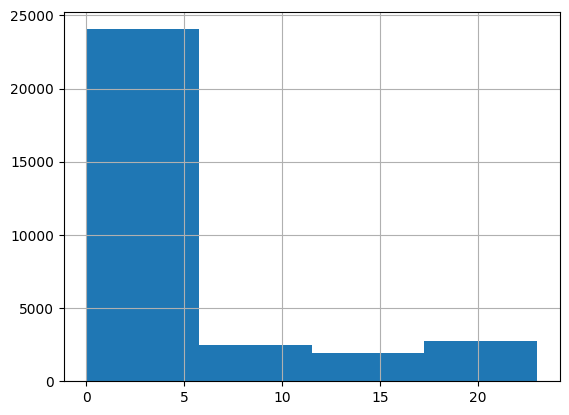

In [66]:
merge_def["coef_ventas"].hist(bins=4)